# Chapter 4. Training Models

Define the default font sizes to make the figures prettier:

In [70]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

generate some linear-looking data to test the normal equation:

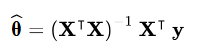

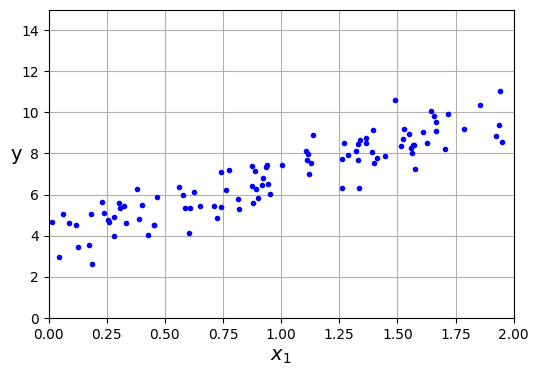

In [71]:
import numpy as np

m = 100 # number of instances
# seed = 42 to make this code reproducible
X = 2 * np.random.default_rng(seed=42).random(size=(m, 1)) # column vector
y = 4 + 3 * X + np.random.default_rng(seed=42).standard_normal(size=(m, 1))

plt.figure(figsize=(6,4))
plt.plot(X, y, "b.")
plt.ylabel("y", rotation=0)
plt.xlabel("$x_1$")
plt.grid()
plt.axis([0, 2, 0, 15])
plt.show()

Now compute the optimal parameters using the normal equation

In [72]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X) # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [73]:
theta_best

array([[3.83280749],
       [3.12011349]])

Not exactly 4 and 3 because of the noise.

In [74]:
# making predictions with theta_best
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new) # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
y_predict

array([[ 3.83280749],
       [10.07303446]])

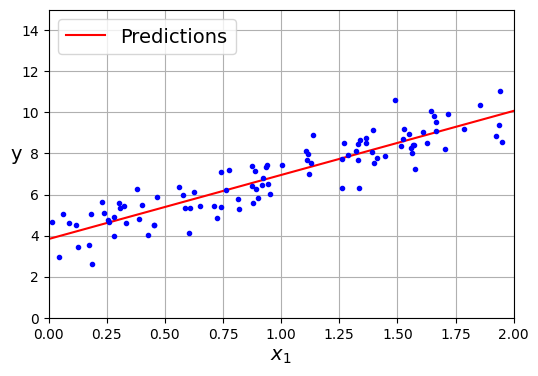

In [75]:
# plot this model's prediction
plt.figure(figsize=(6,4))
plt.plot(X_new, y_predict, "r", label="Predictions")
plt.plot(X, y, "b.")
plt.ylabel("y",rotation=0)
plt.xlabel("$x_1$")
plt.legend(loc="upper left")
plt.axis([0,2,0,15])
plt.grid()

plt.show()

In [76]:
# linear regression using Scikit-Learn 
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.83280749]), array([[3.12011349]]))

In [77]:
lin_reg.predict(X_new)

array([[ 3.83280749],
       [10.07303446]])

The LinearRegression class is based on the scipy.linalg.lstsq() function, which stands for "least squares", which you could call directly:

In [78]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.83280749],
       [3.12011349]])



(specifically, the Moore–Penrose inverse)

In [79]:
# you can us np.linalg.pinv() to compute pseudoinverse directly:
np.linalg.pinv(X_b) @ y

array([[3.83280749],
       [3.12011349]])

In [80]:
%%time
# Let’s look at a quick implementation of gradient descent:
eta = 0.1 # Learning rate
n_epochs = 1000
m = len(X_b) # number of instances

theta = np.random.default_rng(seed=42).random(size=(2,1)) # randomly initialized model parameters

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

CPU times: total: 15.6 ms
Wall time: 23.2 ms


In [81]:
theta 

array([[3.83280749],
       [3.12011349]])

Batch gradient descent for 3 different learning rates:

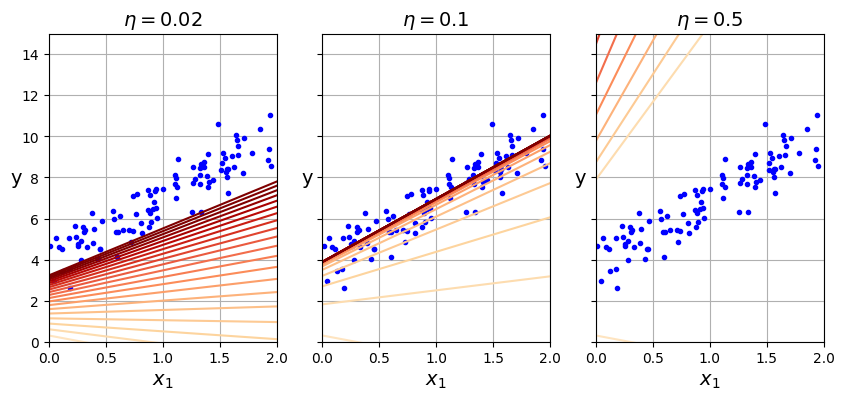

In [82]:
import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
            gradients = 2 / m * X_b.T @ (X_b @ theta - y)
            theta = theta - eta * gradients
            theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

# random initialization
theta = np.random.default_rng(seed=42).standard_normal(size=(2, 1))
theta_path_bgd = None
plt.figure(figsize=(10,  4))
etas = [0.02, 0.1, 0.5]
for i, eta in enumerate(etas):
    plt.subplot(131 + i)
    if i == 1: theta_path_bgd = plot_gradient_descent(theta, eta=eta)
    else: plot_gradient_descent(theta, eta=eta)
    plt.ylabel("y", rotation=0)
    if i > 0: plt.gca().axes.yaxis.set_ticklabels([])

plt.show()

### **Stochastic Gradient Descent**

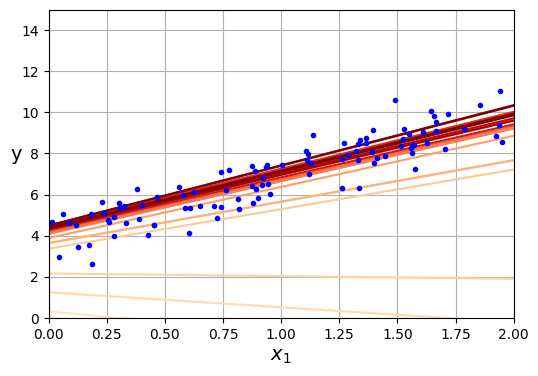

In [83]:
# implementing stochastic gradient descent using a simple learning schedule:
theta_path_sgd = [] # to plot next figure
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

# random initialization
theta = np.random.default_rng(seed=42).standard_normal(size=(2, 1)) 

n_shown = 20 # just needed to generate the figure below
plt.figure(figsize=(6,4))

for epoch in range(n_epochs):
    for iteration in range(m):
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)
            
        random_index = np.random.default_rng().integers(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi) # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()

plt.show()

In [84]:
theta

array([[3.79593897],
       [3.09386209]])

In [85]:
# SGD with Scikit-Learn
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel()) # ravel() because fit() expects 1D targets

,loss,'squared_error'
,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,1e-05
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,42


In [86]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.83108005]), array([3.12187814]))

## **Mini-Batch Gradient Descent**

[[ 0.30471708]
 [-1.03998411]]


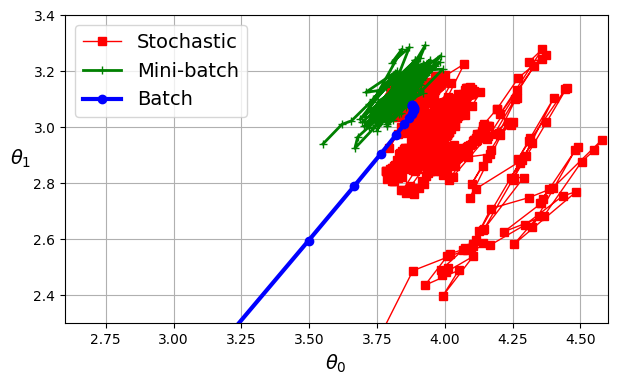

In [87]:
from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

# random initialization
theta = np.random.default_rng(seed=42).standard_normal(size=(2,1))
t0, t1 = 200, 1000 # learning schedules hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta_path_mgd = []
print(theta)
for epoch in range(n_epochs):
    shuffled_indices = np.random.default_rng().permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for iteration in range(n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx : idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * n_batches_per_epoch + iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1,
         label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2,
         label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3,
         label="Batch")
plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.ylabel("$\\theta_1$   ", rotation=0)
plt.axis([2.6, 4.6, 2.3, 3.4])
plt.grid()

plt.show()

## Polynomial Regression

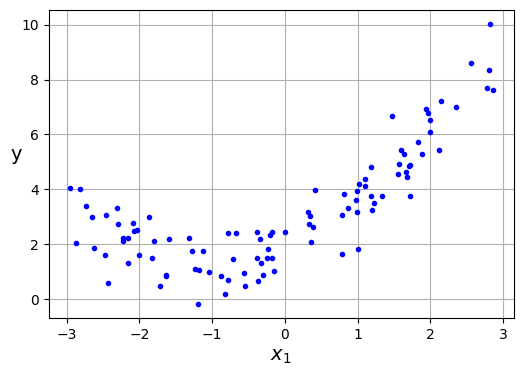

In [88]:
# generate some nonlinear data based on a simple quadratic equation
m = 100
X = 6 * np.random.default_rng(seed=42).random(size=(m,1)) - 3
y= 0.5 * X ** 2 + X + 2 + np.random.default_rng(seed=42).standard_normal(
    size=(m,1))

plt.figure(figsize=(6,4))
plt.plot(X, y, "b.")
plt.ylabel("y",rotation=0)
plt.xlabel("$x_1$")
plt.grid()

plt.show()

In [89]:
# creating polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([1.64373629])

In [90]:
X_poly[0]

array([1.64373629, 2.701869  ])

In [91]:
# fitting a linear regression model to this extended training data
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.95031351]), array([[1.04025741, 0.50098143]]))

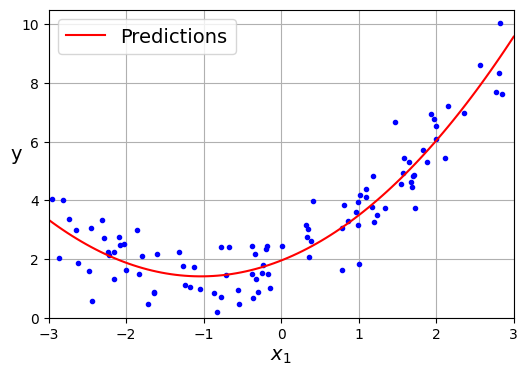

In [92]:
X_new = np.linspace(-3,3, 100).reshape(100,1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6,4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r", label="Predictions")
plt.ylabel("y",rotation=0)
plt.xlabel("$x_1$")
plt.axis([-3,3, 0, 10.5])
plt.grid()
plt.legend(loc="upper left")

plt.show()

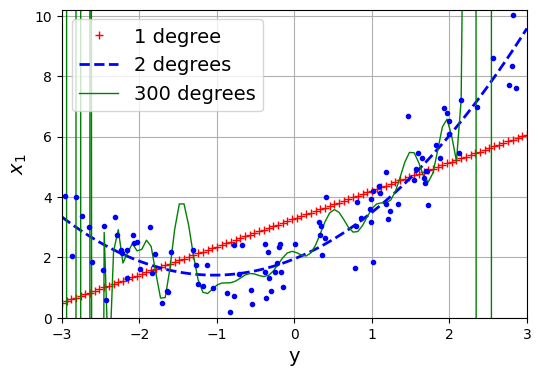

In [93]:
# comparison of polynomial features of 1, 2, and 300 degrees
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6,4))
for degree, width, style in [[1,2,"r+"], [2, 2, "b--"], [300, 1, "g"]]:
    pipeline = make_pipeline(PolynomialFeatures(
        degree=degree, include_bias=False),
            StandardScaler(), LinearRegression())
    pipeline.fit(X, y)
    plt.plot(X_new, pipeline.predict(X_new), style, linewidth=width,
             label=f"{degree} degree{"s" if degree > 1 else ""}")
    

plt.plot(X, y, "b.")
plt.grid()
plt.legend(loc="upper left")
plt.xlabel("y")
plt.ylabel("$x_1$")
plt.axis([-3,3, 0, 10.2])

plt.show()

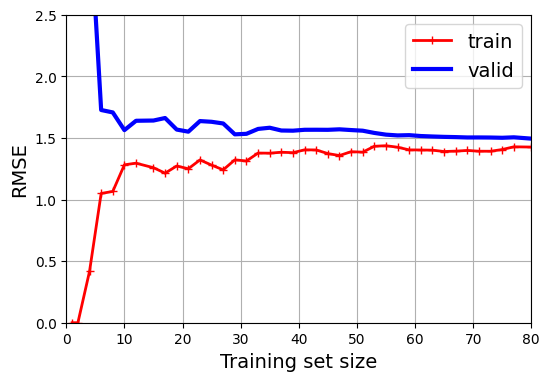

In [94]:
# showing function learning_curve() 
# model is underfitting
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0,80,0, 2.5])
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.show()

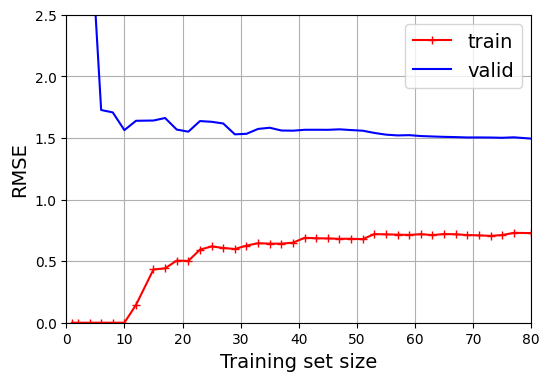

In [95]:
# learning curve of a 10th-degree polynomial model on the same data
# model is overfitting
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_scores = -valid_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_errors, "r-+", label="train")
plt.plot(train_sizes, valid_errors, "b", label="valid")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.show()

## **Regularization**

### Ridge Regression

In [96]:
# creating the dataset
m = 20
X = 3 * np.random.default_rng(seed=42).random(size=(m,1))
y = 1 + 0.5 * X + np.random.default_rng(seed=42).standard_normal(size=(m,1))/ 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

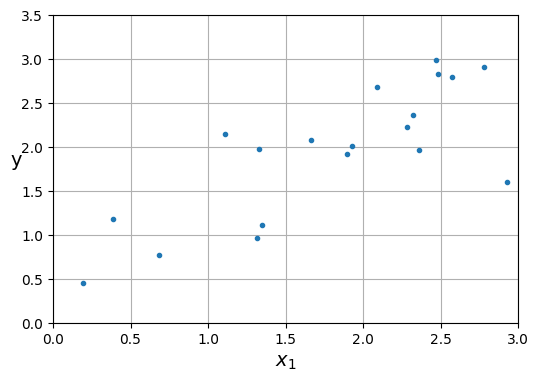

In [97]:
# a peek at the generated dataset
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

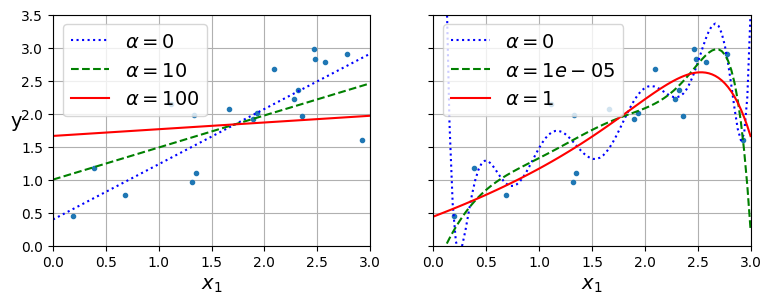

In [98]:
# Ridge regression 1st degree (left) and 10th degree (right)
from sklearn.linear_model import Ridge

styles = ["b:", "g--", "r-"]
alphas_per_polyFeatures = [[0, 10, 100], [0, 1e-5, 1]]

plt.figure(figsize=(9, 3))
for i, alphas in enumerate(alphas_per_polyFeatures):
    plt.subplot(121 + i)
    plt.xlabel("$x_1$")
    plt.plot(X, y, ".")
    for style, alpha in zip(styles, alphas):
        model = Ridge(alpha, random_state=42)            
        if i:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                Ridge(alpha, random_state=42))
        model.fit(X, y)
        plt.plot(X_new, model.predict(X_new), style,
                 label=fr"$\alpha = {alpha}$")
    if not i: plt.ylabel("y", rotation=0)
    else: plt.gca().axes.yaxis.set_ticklabels([])
    plt.grid()
    plt.legend(loc="upper left")
    plt.axis([0, 3, 0, 3.5])

plt.show()

In [99]:
# perform ridge regression with Scikit-learn using a closed-form solution
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([1.65469289])

In [100]:
# using stochastic gradient descent
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1/m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel()) # y.ravel() because fit() expect 1D targets
sgd_reg.predict([[1.5]])

array([1.65475468])

### Lasso Regression

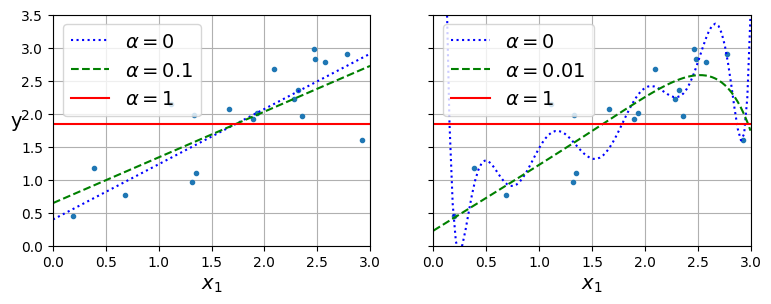

In [101]:
# Lasso regression 1st degree (left) and 10th degree (right)
from sklearn.linear_model import Lasso

styles = ["b:", "g--", "r-"]
alphas_per_polyFeatures = [[0, 0.1, 1], [0, 0.01, 1]]

plt.figure(figsize=(9, 3))
for i, alphas in enumerate(alphas_per_polyFeatures):
    plt.subplot(121 + i)
    plt.xlabel("$x_1$")
    plt.plot(X, y, ".")
    for style, alpha in zip(styles, alphas):
        estimator = None
        if alpha > 0: estimator = Lasso(alpha, random_state=42)
        else: estimator = LinearRegression()
        model = estimator
        if i:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                estimator)
        model.fit(X, y)
        plt.plot(X_new, model.predict(X_new), style,
                 label=fr"$\alpha = {alpha}$")
    if not i: plt.ylabel("y", rotation=0)
    else: plt.gca().axes.yaxis.set_ticklabels([])
    plt.grid()
    plt.legend(loc="upper left")
    plt.axis([0, 3, 0, 3.5])

plt.show()

In [102]:
# Scikit-Learn example using Lasso Class:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([1.68536698])

### **Elastic Net**

In [103]:
# simple example of Elastic Net regression
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([1.68078017])

### **Early Stopping**

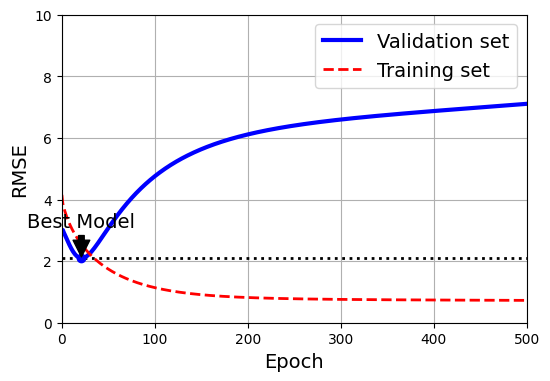

In [104]:
# example of early stopping
from copy import deepcopy
from sklearn.metrics import root_mean_squared_error

m = 100
X = 6 * np.random.default_rng(seed=42).random(size=(m, 1)) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.default_rng(seed=42).standard_normal(
    size=(m ,1))
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2:, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float("inf")
train_errors, val_errors = [], []

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = root_mean_squared_error(y_valid, y_valid_predict)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # saving values for generating the figure
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = root_mean_squared_error(y_train, y_train_predict)
    val_errors.append(val_error)
    train_errors.append(train_error)

best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate("Best Model",
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor="black", shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 10])
plt.grid()

plt.show()
    
    

# Logistic Regression

In [105]:
# load iris dataset 
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [106]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [107]:
iris.target.head(3)

0    0
1    0
2    0
Name: target, dtype: int32

In [108]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [109]:
# train logistic regression to classify Iris virginica only
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == "virginica"
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


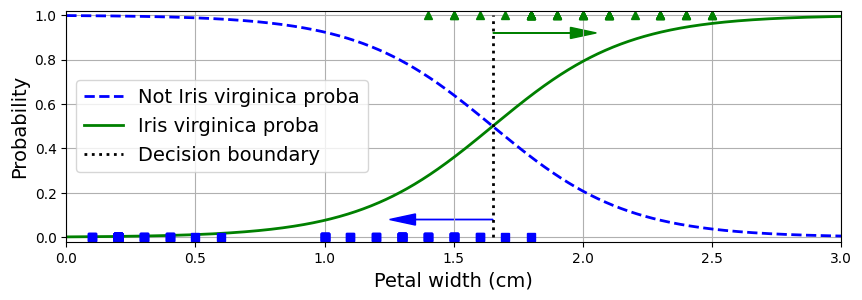

In [110]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1) # reshape to get a column vector
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(10,3))
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")
plt.grid()
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
         head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
         head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.legend(loc="center left")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.axis([0, 3, -0.02, 1.02])
plt.show()


### **Softmax regression**

In [111]:
# using softmax to classify the iris plant into all 3 classes.
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =42)
# scikit-learn's logistic regression classifier uses softmax regression
# automatically when it is trained on more than 2 classes
softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,30
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [112]:
softmax_reg.predict([[5, 2]])

array([2])

In [113]:
softmax_reg.predict_proba([[5,2]]).round(2)

array([[0.  , 0.04, 0.96]])

In [114]:
from sklearn.metrics import accuracy_score
y_test_pred = softmax_reg.predict(X_test)
accuracy_score(y_test, y_test_pred) # Wow! 100% accuracy

1.0

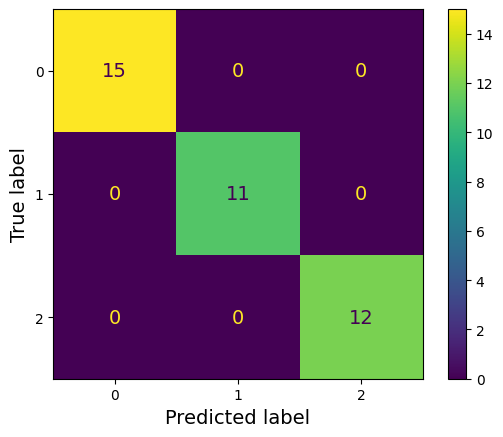

In [115]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

## Coding question

12. Implement batch gradient descent with early stopping for softmax regression
without using Scikit-Learn, only NumPy. Use it on a classification task such
as the iris dataset.

In [116]:
class SoftMax(object):
    def __init__(self, epochs=100, patience=None, eta0=1e-3, valid_set_ratio=0.2, random_state=None):
        """epochs (int): maximum number of iterations the model will train
           patience (int): number of training iterations the model will do before stopping if there is no reduction in the loss.
               None means the model will not use early stop
           eta0 (float): learning rate
           valid_set_ratio (float, 0 - 1): ratio of the training data that will be held out for measuring validation loss
           random_state (int): to make the code reproducible
           X and y datasets should be numpy array
           target values should be integers (0 to number of classes - 1)
        """
        self.epochs = epochs
        self.patience = patience
        self.random_state = random_state
        self.initialized = False # to tell the model if it is fitting the training data for the first time so it can initiazlize the parameters
        self.eta0 = eta0
        self.valid_set_ratio = valid_set_ratio
        
    def predict_proba(self, X):
        # compute probability that the instance belongs to each class
        unnormalized_proba = np.exp(X @ self.coef_ + self.bias_)
        proba = unnormalized_proba / unnormalized_proba.sum(axis=1).reshape(-1,1)
        return proba

    def predict(self, X):
        return (X @ self.coef_ + self.bias_).argmax(axis=1)

    def gradient(self, X, y):
        # compute the gradient for each model parameters
        proba = self.predict_proba(X)
        y_true = np.zeros(shape=(X.shape[0], self.num_classes_))
        y_true[range(y_true.shape[0]), y] = 1
        difference = proba - y_true
        return (X.T @ (difference)) / X.shape[0], difference.sum(axis=0) / X.shape[0]
        
    def cross_entropy_loss(self, X, y):
        # compute model's cross entropy loss
        y_true = np.zeros(shape=(X.shape[0], self.num_classes_))
        y_true[range(X.shape[0]), y] = 1
        log = np.log(self.predict_proba(X))
        return -np.sum(y_true * log) / X.shape[0]

    def initialize(self):
        # initialize model parameters and number of classes
        self.initialized = True
        self.num_classes_ = np.unique(y).shape[0]
        self.bias_ = np.random.default_rng(seed=self.random_state).standard_normal(size=self.num_classes_)
        self.coef_ = np.random.default_rng(seed=self.random_state).standard_normal(size=(X.shape[1], self.num_classes_))
        
    def fit(self, X, y):
        # fit model normally or with early stop if patience is not None
        self.initialize()
        if not self.patience:
            for i in range(self.epochs):
                self.partial_fit(X, y)
        else:    
            X_train, X_valid, y_train, y_valid = self.stratified_split(X, y)
            best_cost = self.cross_entropy_loss(X_valid, y_valid)
            best_params = [self.coef_.copy(), self.bias_.copy()]
            patience = self.patience
            for i in range(self.epochs):
                self.partial_fit(X_train, y_train)
                cost = self.cross_entropy_loss(X_valid, y_valid)
                if cost < best_cost:
                    best_cost = cost
                    best_params = [self.coef_.copy(), self.bias_.copy()]
                    patience = self.patience
                else:
                    patience -= 1

            self.coef_ = best_params[0]
            self.bias_ = best_params[1] 
        return self
            
        
    def partial_fit(self, X, y):
        # fit the model once and initialize model parameters if not initialized yet
        if not self.initialized: self.initialize()
        gradients = self.gradient(X, y)
        self.coef_ -= self.eta0 * gradients[0]
        self.bias_ -= self.eta0 * gradients[1]

        return self
        
    def stratified_split(self, X, y):
        # stratified split the data into train and validation sets for early stop feature
        X_train_index = np.array([], dtype=np.int32)
        X_valid_index = np.array([], dtype=np.int32)
        y_train_index = np.array([], dtype=np.int32)
        y_valid_index = np.array([], dtype=np.int32)
        shuffled_index = np.random.default_rng(seed=self.random_state).permutation(y.shape[0])
        for unique_label in np.unique(y):
            indexes = shuffled_index[y == unique_label]
            stop_index = int(indexes.shape[0]*self.valid_set_ratio)
            X_train_index = np.concatenate((X_train_index, shuffled_index[indexes[stop_index:]]))
            X_valid_index = np.concatenate((X_valid_index, shuffled_index[indexes[:stop_index]]))
            y_train_index = np.concatenate((y_train_index, shuffled_index[indexes[stop_index:]]))
            y_valid_index = np.concatenate((y_valid_index, shuffled_index[indexes[:stop_index]]))
        return X[X_train_index], X[X_valid_index], y[y_train_index], y[y_valid_index]

    def fit_plot_early_stop(self, X, y):
        # fit model and plot cost on the training data and validation data
        self.initialize()
        valid_costs = np.empty(shape=self.epochs + 1)
        train_costs = np.empty(shape=self.epochs + 1)
        X_train, X_valid, y_train, y_valid = self.stratified_split(X, y)
        best_cost_index = 0
        best_params = [self.coef_.copy(), self.bias_.copy()]
        train_costs[0] = self.cross_entropy_loss(X_train, y_train)
        valid_costs[0] = self.cross_entropy_loss(X_valid, y_valid)
        for i in range(self.epochs):
            self.partial_fit(X_train, y_train)
            train_costs[i + 1] = self.cross_entropy_loss(X_train, y_train)
            valid_costs[i + 1] = self.cross_entropy_loss(X_valid, y_valid)
            if valid_costs[i + 1] < valid_costs[best_cost_index]:
                best_cost_index = i + 1
                best_params = [self.coef_.copy(), self.bias_.copy()]

        self.coef_ = best_params[0]
        self.bias_ = best_params[1]

        plt.plot(range(self.epochs + 1), train_costs, "b-", linewidth=1, label="Train error")
        plt.plot(range(self.epochs + 1), valid_costs, "r-", linewidth=1, label="Validation error")
        plt.xlabel("Epoch")
        plt.ylabel("Cross Entropy loss")
        plt.title("Train vs Validation error per epoch")
        plt.grid()
        plt.legend(loc="upper right")
        plt.annotate("Best Model",
             xy=(best_cost_index, valid_costs[best_cost_index]),
             xytext=(best_cost_index, valid_costs[best_cost_index] + 1),
             ha="center",
             arrowprops=dict(facecolor="black", shrink=0.05))


# since I cannot use scikit-learn's accuracy function, I created my own    
def my_accuracy(y_true, y_pred):
    return y_true[y_true == y_pred].shape[0] / y_true.shape[0]

0.9464285714285714


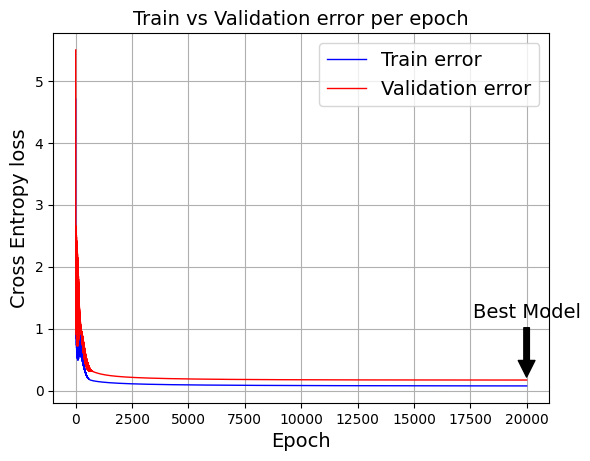

In [117]:
softmax = SoftMax(eta0=0.5,epochs=20000, random_state=42) # I did a lot of fine-tuning to find this eta0
softmax.fit_plot_early_stop(X_train, np.array(y_train))
print(my_accuracy(y_train, softmax.predict(X_train)))
plt.show()

The learning rate is a bit high because the model's loss jumped up and down for the first 500 epochs but the model converged. Early stop does not do anything here except for maybe stopping with worse parameters if patience is set too low. Still, let's see the model's performance with both early stop and normal batch gradient descent.

In [118]:
softmax.patience = 500
softmax.fit(X_train, np.array(y_train))
print("With early stop:", my_accuracy(y_train, softmax.predict(X_train)))
softmax.patience = None
softmax.fit(X_train, np.array(y_train))
print("Without early stop:", my_accuracy(y_train, softmax.predict(X_train)))

With early stop: 0.9464285714285714
Without early stop: 0.9464285714285714


Cool! I thought that, since the model with early stop trains on less data to create the validation set, the model would perform worse but patience is set to high enough so it does not bring trouble!

In [119]:
# see performance on test data
print("Test accuracy:", my_accuracy(y_test, softmax.predict(X_test)))

Test accuracy: 1.0


Yay! My implementation also got 100% accuracy on the test set!

### Question 12 answer by the author

Let's start by loading the data. We will just reuse the Iris dataset we loaded earlier.

In [120]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

We need to add the bias term for every instance ($x_0 = 1$). The easiest option to do this would be to use Scikit-Learn's `add_dummy_feature()` function, but the point of this exercise is to get a better understanding of the algorithms by implementing them manually. So here is one possible implementation:

In [121]:
X_with_bias = np.c_[np.ones(len(X)), X]

The easiest option to split the dataset into a training set, a validation set and a test set would be to use Scikit-Learn's `train_test_split()` function, but again, we want to do it manually:

In [122]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.default_rng(seed=42).permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for any given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance. To understand this code, you need to know that `np.diag(np.ones(n))` creates an n×n matrix full of 0s except for 1s on the main diagonal. Moreover, if `a` is a NumPy array, then `a[[1, 3, 2]]` returns an array with 3 rows equal to `a[1]`, `a[3]` and `a[2]` (this is [advanced NumPy indexing](https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing)).

In [123]:
def to_one_hot(y):
    return np.diag(np.ones(y.max() + 1))[y]

In [124]:
y_train[:10]

array([1, 1, 2, 0, 2, 2, 1, 2, 2, 0])

In [125]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

Looks good, so let's create the target class probabilities matrix for the training set and the test set:

In [126]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

Now let's scale the inputs. We compute the mean and standard deviation of each feature on the training set (except for the bias feature), then we center and scale each feature in the training set, the validation set, and the test set:

In [127]:
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [128]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps / exp_sums

We are almost ready to start training. Let's define the number of inputs and outputs:

In [129]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train)) # == 3 (there are 3 iris classes)

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

In [130]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5

Theta = np.random.default_rng(seed=42).standard_normal((n_inputs, n_outputs))

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        print(epoch, xentropy_losses.sum(axis=1).mean())
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    Theta -= eta * gradients

0 2.973977344302766
1000 0.09313918303944396
2000 0.0890469894612578
3000 0.08847558719791132
4000 0.08861927669821175
5000 0.08894346006981158


And that's it! The Softmax model is trained. Let's look at the model parameters:

In [131]:
Theta

array([[-1.23843975,  5.9045082 , -4.65088428],
       [-6.53446858, -2.85065468,  7.07247328],
       [-6.919744  , -0.36831947,  7.08286012]])

Let's make predictions for the validation set and check the accuracy score:

In [132]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

Well, this model looks pretty ok. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [133]:
eta = 0.5
n_epochs = 5001
epsilon = 1e-5
alpha = 0.01 # regularization hyperparameter

Theta = np.random.default_rng(seed=42).standard_normal((n_inputs, n_outputs))

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
        total_loss = xentropy_losses.sum(axis=1).mean() + alpha * l2_loss
        print(epoch, total_loss.round(4))
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.0065
1000 0.2711
2000 0.2711
3000 0.2711
4000 0.2711
5000 0.2711


Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? Let's find out:

In [134]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predicts = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

In this case, the $\ell_2$ penalty did not change the test accuracy. Perhaps try fine-tuning `alpha`?

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [135]:
eta = 0.5
n_epochs = 50_001
m = len(X_train)
epsilon = 1e-5
C = 100 # regularization hyperparameter
best_loss = np.inf

Theta = np.random.default_rng(seed=42).standard_normal((n_inputs, n_outputs))

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + 1/C * l2_loss
    if epoch % 1000 == 0:
        print(epoch, total_loss.round(4))
    if total_loss < best_loss:
        best_loss = total_loss
    else:
        print(epoch - 1, best_loss.round(4))
        print(epoch, total_loss.round(4), "early stopping")
        break
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
    Theta -= eta * gradients
    

0 3.0065
402 0.2711
403 0.2711 early stopping


In [136]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accurcay_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

Oh well, still no change in validation accuracy, but at least early stopping shortened training a bit.

Now let's plot the model's predictions on the whole dataset (remember to scale all features fed to the model):

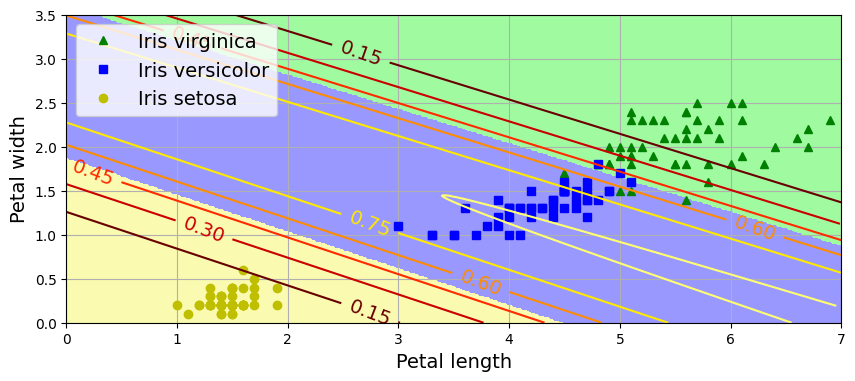

In [137]:
custom_cmap = mpl.colors.ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

logits = X_new_with_bias @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

And now let's measure the final model's accuracy on the test set:

In [138]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

0.9666666666666667

Well we get even better performance on the test set. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.